# Data Science Capstone Project

## Summary:
* [Business Problem](#business_problem)
* [Data understanding](#data_understanding)
* [Exploratory Data Analysis](#eda)
* [Modeling](#modeling)
* [Evaluation](#evaluation)
* [Conclusion](#conclusion)

## Business problem <a name="business_problem"></a>

Todos os anos, várias pessoas morrem por acidentes de carros, seja por desatenção, algo na pista que causou o acidente, a iluminação, fatores externos, etc. Muitos sofrem acidentes e não recebem o cuidado necessário de imediato, causando a morte do individuo no caminho ao hospital, no local do acidente ou posteriormente.
O foco desse projeto será tentar prever a gravidade de um acidente, baseado em dados anteriores de acidentes, para ajudar autoridades, hospitais, serviços de saúde pública e, claro, o próprio motorista.
Para isso, vamos usar algoritmos de aprendizagem supervisionada de Machine Learning para prever a gravidade de acidentes futuros e poder alertar os orgãos responsáveis para trabalhar no acidente e tentar reduzir o nível de fatalidade de acidentes.

## Data understanding <a name="data_understanding"></a>

Os dados que iremos usar vem do SDOT Traffic Management Division, Traffic Records Group, em formato CSV. Os dados são de Seattle, e datam de 2004 até os dias atuais, são dados atualizados semanalmente, então, posteriormente, podemos fazer com que nosso modelo absorva mais dados futuros, tanto para melhorar a acuracia, quanto para procurar novas tendencias nos dados e entregar um melhor resultado.
Dentro do arquivo CSV temos colunas que representam tipos de dados diversos, tais como a data do acidente, condições da pista, numero de acidentados, quantidade de carros involvidos, pedestres, ciclistas, etc. Também temos muitas colunas que servem apenas para identificação de cada acidente por orgãos que lidam com esse tipo de trabalho. Além disso, temos muitos valores vazios e desconhecidos que precisamos lidar com algumas técnicas.
Podemos ter mais informações de cada coluna no arquivo <b>METADATA.pdf</b> para saber pra que cada variável serve.
A coluna que precisamos prever é a "SEVERITYCODE" que tem o valor da gravidade do acidente, quanto maior, maior a gravidade. Através de algumas analises, podemos ver que atualmente iremos lidar com apenas dois valores: 1 ou 2 (dano apenas a propriedades e pessoas machucadas no acidente, respectivamente).
Um forte candidato para decisão binária (onde só há duas possibilidades) é usar o algoritmo de Regressão Logística, porém iremos tentar outros algoritmos para ver qual tem uma melhor avaliação.

### Importing libraries

In [1]:
# Pandas to handle dataset
import pandas as pd 

# Numpy to handle and operate through arrays
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Removing warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
# Read the dataset
df_collisions = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv")

 ## Exploratory data analysis <a name="eda"></a>

In this dataset, we have a lot of columns that are only used for identification by the authorities, so we need to remove these useless columns to make our DataFrame smaller and use only the columns that have impact in our decisions.
For more info about these columns, check the <b>Metadata.pdf</b>

In [4]:
useless_columns = ['OBJECTID', 'X', 'Y', 'REPORTNO', 'STATUS', 'INCDTTM', 'INCKEY', 'COLDETKEY', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'INCDATE', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'SDOTCOLNUM', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY']

df_collisions.drop(columns=useless_columns, inplace=True)

print(df_collisions.columns)

Index(['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER',
       'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR'],
      dtype='object')


Let's check the first five rows in the dataframe and check the type of each column

In [5]:
df_collisions.head()

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR
0,2,Intersection,Angles,2,0,0,2,NaN,N,Overcast,Wet,Daylight,NaN,NaN,N
1,1,Block,Sideswipe,2,0,0,2,NaN,0,Raining,Wet,Dark - Street Lights On,NaN,NaN,N
2,1,Block,Parked Car,4,0,0,3,NaN,0,Overcast,Dry,Daylight,NaN,NaN,N
3,1,Block,Other,3,0,0,3,NaN,N,Clear,Dry,Daylight,NaN,NaN,N
4,2,Intersection,Angles,2,0,0,2,NaN,0,Raining,Wet,Daylight,NaN,NaN,N


In [6]:
df_collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   SEVERITYCODE    194673 non-null  int64 
 1   ADDRTYPE        192747 non-null  object
 2   COLLISIONTYPE   189769 non-null  object
 3   PERSONCOUNT     194673 non-null  int64 
 4   PEDCOUNT        194673 non-null  int64 
 5   PEDCYLCOUNT     194673 non-null  int64 
 6   VEHCOUNT        194673 non-null  int64 
 7   INATTENTIONIND  29805 non-null   object
 8   UNDERINFL       189789 non-null  object
 9   WEATHER         189592 non-null  object
 10  ROADCOND        189661 non-null  object
 11  LIGHTCOND       189503 non-null  object
 12  PEDROWNOTGRNT   4667 non-null    object
 13  SPEEDING        9333 non-null    object
 14  HITPARKEDCAR    194673 non-null  object
dtypes: int64(5), object(10)
memory usage: 22.3+ MB


### Missing values

Now, let's check our dataframe for missing values and how we'll handle then.

In [7]:
df_collisions.isnull().sum()

SEVERITYCODE           0
ADDRTYPE            1926
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SPEEDING          185340
HITPARKEDCAR           0
dtype: int64

We can use 3 methods to handle missing data:
 - replacing by column average;
 - replacing by column most recurring value; or
 - deleting entire row/column with missing data

We can drop columns with 50% or more missing values

In [8]:
print('Inital total columns: ' + str(np.asarray(df_collisions.columns).size))

df_collisions.dropna(axis=1, thresh=97336, inplace=True)

print('Total columns after dropping: ' + str(np.asarray(df_collisions.columns).size))

Inital total columns: 15
Total columns after dropping: 12


In [9]:
# Dataset is imbalanced, so lets grab samples and balance that using undersampling technique
df_collisions.SEVERITYCODE.value_counts()

df_shuffled = df_collisions.sample(frac=1)

df_severitycode_2 = df_shuffled.loc[df_shuffled['SEVERITYCODE'] == 2]
df_severitycode_1 = df_shuffled.loc[df_shuffled['SEVERITYCODE'] == 1].sample(n=58188)

df_collisions = pd.concat([df_severitycode_1, df_severitycode_2])
df_collisions.SEVERITYCODE.value_counts()

2    58188
1    58188
Name: SEVERITYCODE, dtype: int64

<p>Since the remaing columns with missing values are categorical, we can fill those missing values with the recurrent value</p>

In [10]:
cols_with_missing_values = ['ADDRTYPE', 'COLLISIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND']

df_collisions[cols_with_missing_values].head()

,ADDRTYPE,COLLISIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
109646,Block,Other,Y,Clear,Ice,Dark - Street Lights On
102847,Block,Rear Ended,N,Raining,Wet,Daylight
107264,Intersection,Left Turn,N,Clear,Dry,Daylight
171037,Block,Parked Car,N,Clear,Dry,Dark - Street Lights On
48397,Block,Rear Ended,0,Clear,Dry,Daylight


We can see that UNDERINFL column has numeric and string values, so we need to handle it individually. We can replace 0 with 'No' and 1 with 'Yes' values.

In [11]:
df_collisions['UNDERINFL'] = df_collisions['UNDERINFL'].map({'0': 'No', '1': 'Yes', 'N': 'No', 'Y': 'Yes'})

Now lets fill those missing values with the recurrent value

In [12]:
df_collisions['ADDRTYPE'].fillna(df_collisions['ADDRTYPE'].mode()[0], inplace=True)
df_collisions['COLLISIONTYPE'].fillna(df_collisions['COLLISIONTYPE'].mode()[0], inplace=True)
df_collisions['UNDERINFL'].fillna(df_collisions['UNDERINFL'].mode()[0], inplace=True)
df_collisions['WEATHER'].fillna(df_collisions['WEATHER'].mode()[0], inplace=True)
df_collisions['ROADCOND'].fillna(df_collisions['ROADCOND'].mode()[0], inplace=True)
df_collisions['LIGHTCOND'].fillna(df_collisions['LIGHTCOND'].mode()[0], inplace=True)

### Data Wrangling

Now, lets use <b>OneHotEncoding</b> and <b>get_dummies</b> to handle categorical values

In [13]:
df_collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116376 entries, 109646 to 142417
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   SEVERITYCODE   116376 non-null  int64 
 1   ADDRTYPE       116376 non-null  object
 2   COLLISIONTYPE  116376 non-null  object
 3   PERSONCOUNT    116376 non-null  int64 
 4   PEDCOUNT       116376 non-null  int64 
 5   PEDCYLCOUNT    116376 non-null  int64 
 6   VEHCOUNT       116376 non-null  int64 
 7   UNDERINFL      116376 non-null  object
 8   WEATHER        116376 non-null  object
 9   ROADCOND       116376 non-null  object
 10  LIGHTCOND      116376 non-null  object
 11  HITPARKEDCAR   116376 non-null  object
dtypes: int64(5), object(7)
memory usage: 11.5+ MB


####  One-hot Encoding

In [14]:
# ADDRTYPE
df_collisions.ADDRTYPE.value_counts()

Block           72466
Intersection    43529
Alley             381
Name: ADDRTYPE, dtype: int64

In [15]:
# COLLISIONTYPE
df_collisions.COLLISIONTYPE.value_counts()

Rear Ended    25815
Angles        22552
Parked Car    21884
Other         13700
Sideswipe      9286
Left Turn      8936
Pedestrian     6223
Cycles         5009
Right Turn     1616
Head On        1355
Name: COLLISIONTYPE, dtype: int64

In [16]:
# UNDERINFL
df_collisions.UNDERINFL.value_counts()

No     110451
Yes      5925
Name: UNDERINFL, dtype: int64

In [17]:
# COLLISIONTYPE
df_collisions.HITPARKEDCAR.value_counts()

N    113069
Y      3307
Name: HITPARKEDCAR, dtype: int64

<AxesSubplot:xlabel='HITPARKEDCAR', ylabel='SEVERITYCODE'>

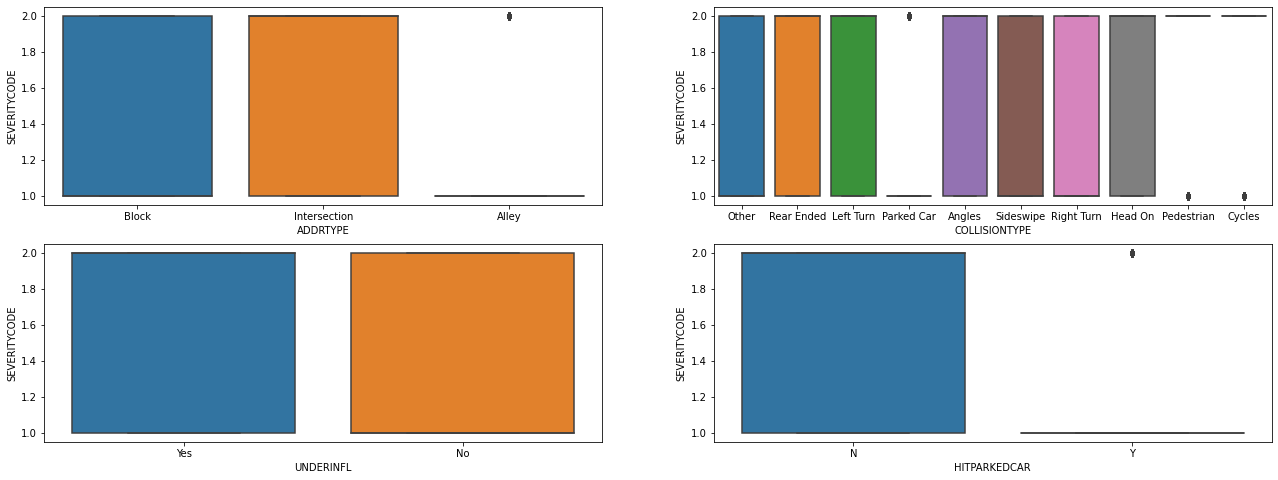

In [18]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(2, 2, 1)
sns.boxplot(data=df_collisions, x='ADDRTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 2)
sns.boxplot(data=df_collisions, x='COLLISIONTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 3)
sns.boxplot(data=df_collisions, x='UNDERINFL', y='SEVERITYCODE')

fig.add_subplot(2, 2, 4)
sns.boxplot(data=df_collisions, x='HITPARKEDCAR', y='SEVERITYCODE')

<AxesSubplot:xlabel='HITPARKEDCAR', ylabel='SEVERITYCODE'>

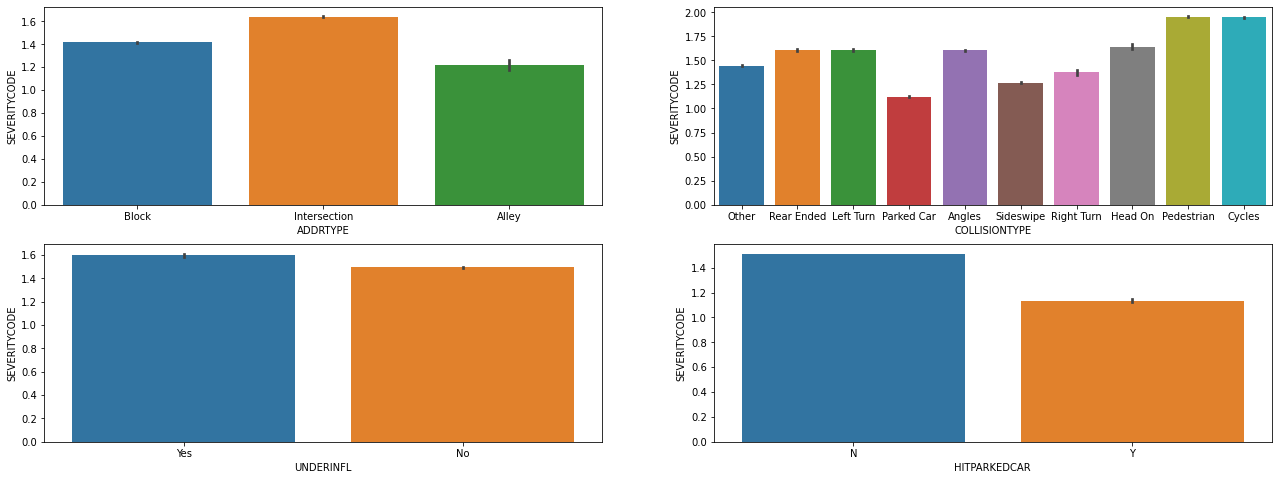

In [19]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(2, 2, 1)
sns.barplot(data=df_collisions, x='ADDRTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 2)
sns.barplot(data=df_collisions, x='COLLISIONTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 3)
sns.barplot(data=df_collisions, x='UNDERINFL', y='SEVERITYCODE')

fig.add_subplot(2, 2, 4)
sns.barplot(data=df_collisions, x='HITPARKEDCAR', y='SEVERITYCODE')

<AxesSubplot:xlabel='HITPARKEDCAR', ylabel='SEVERITYCODE'>

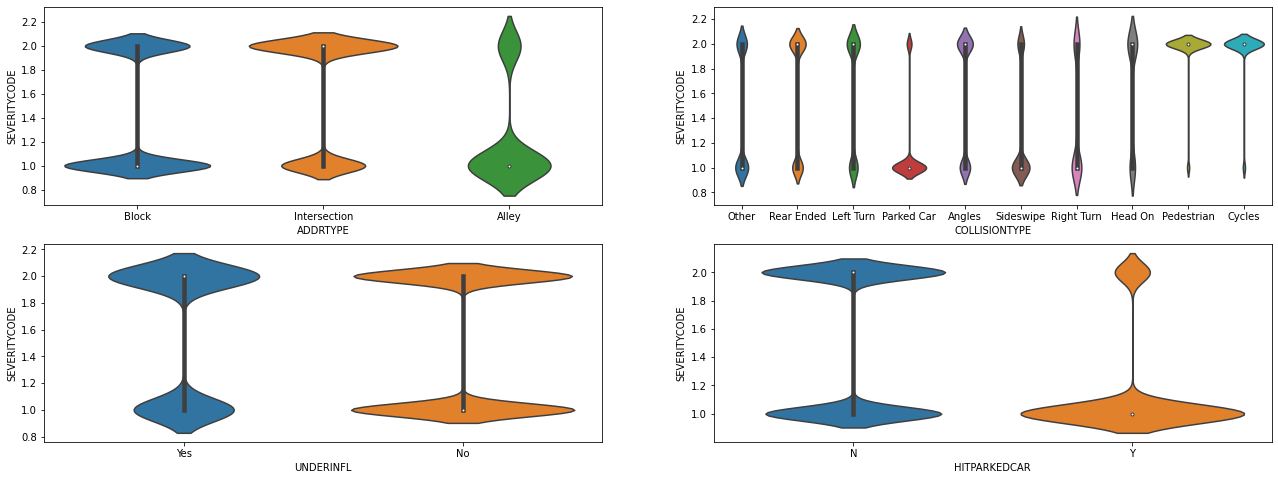

In [20]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(2, 2, 1)
sns.violinplot(data=df_collisions, x='ADDRTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 2)
sns.violinplot(data=df_collisions, x='COLLISIONTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 3)
sns.violinplot(data=df_collisions, x='UNDERINFL', y='SEVERITYCODE')

fig.add_subplot(2, 2, 4)
sns.violinplot(data=df_collisions, x='HITPARKEDCAR', y='SEVERITYCODE')

Since there's no number sequencing in these columns's values, we can use get_dummies in the columns above

In [21]:
object_columns = ['ADDRTYPE', 'COLLISIONTYPE', 'UNDERINFL', 'HITPARKEDCAR']
df_collisions = pd.get_dummies(df_collisions, prefix=['addrtype', 'collisiontype', 'underinfl', 'hitparkedcar'], prefix_sep='_', columns=object_columns, drop_first=True)

#### Label encoding

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
# WEATHER
df_collisions.WEATHER.value_counts()

Clear                       70808
Raining                     20534
Overcast                    16788
Unknown                      6850
Snowing                       498
Other                         431
Fog/Smog/Smoke                351
Sleet/Hail/Freezing Rain       66
Blowing Sand/Dirt              30
Severe Crosswind               15
Partly Cloudy                   5
Name: WEATHER, dtype: int64

In [24]:
# ROADCOND
df_collisions.ROADCOND.value_counts()

Dry               78891
Wet               29222
Unknown            6803
Ice                 678
Snow/Slush          539
Other                82
Standing Water       65
Sand/Mud/Dirt        49
Oil                  47
Name: ROADCOND, dtype: int64

In [25]:
# COLLISIONTYPE
df_collisions.LIGHTCOND.value_counts()

Daylight                    74433
Dark - Street Lights On     29099
Unknown                      6074
Dusk                         3635
Dawn                         1513
Dark - No Street Lights       831
Dark - Street Lights Off      664
Other                         121
Dark - Unknown Lighting         6
Name: LIGHTCOND, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Dark - Street Lights On'),
  Text(1, 0, 'Daylight'),
  Text(2, 0, 'Unknown'),
  Text(3, 0, 'Dusk'),
  Text(4, 0, 'Dawn'),
  Text(5, 0, 'Dark - Street Lights Off'),
  Text(6, 0, 'Dark - No Street Lights'),
  Text(7, 0, 'Dark - Unknown Lighting'),
  Text(8, 0, 'Other')])

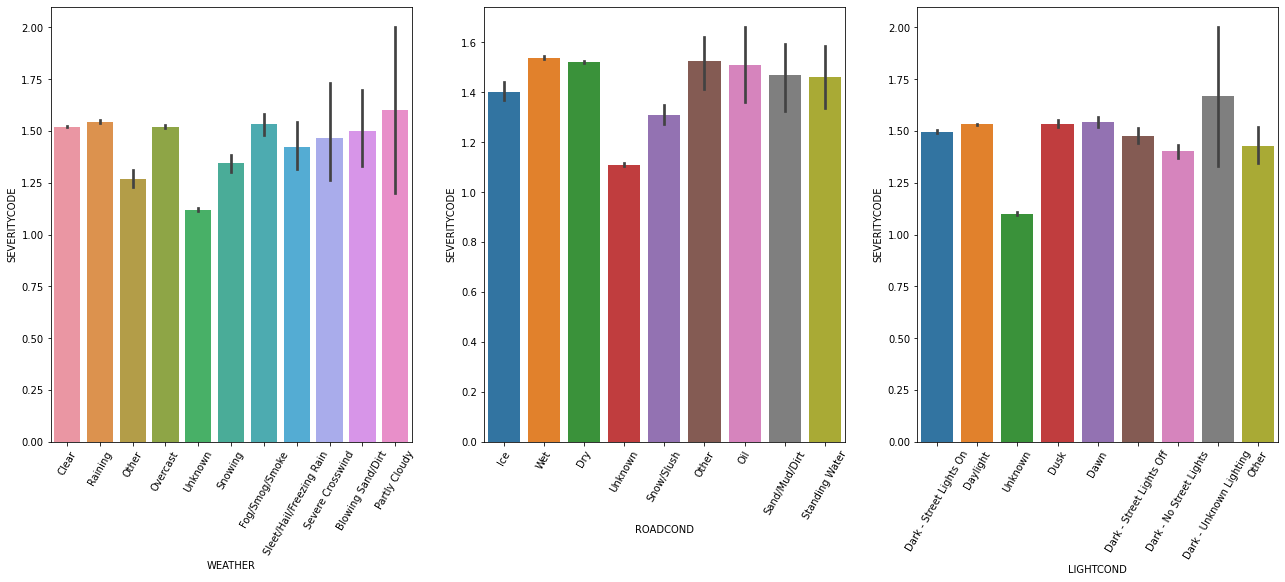

In [26]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(1, 3, 1)
sns.barplot(data=df_collisions, x='WEATHER', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 2)
sns.barplot(data=df_collisions, x='ROADCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 3)
sns.barplot(data=df_collisions, x='LIGHTCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Dark - Street Lights On'),
  Text(1, 0, 'Daylight'),
  Text(2, 0, 'Unknown'),
  Text(3, 0, 'Dusk'),
  Text(4, 0, 'Dawn'),
  Text(5, 0, 'Dark - Street Lights Off'),
  Text(6, 0, 'Dark - No Street Lights'),
  Text(7, 0, 'Dark - Unknown Lighting'),
  Text(8, 0, 'Other')])

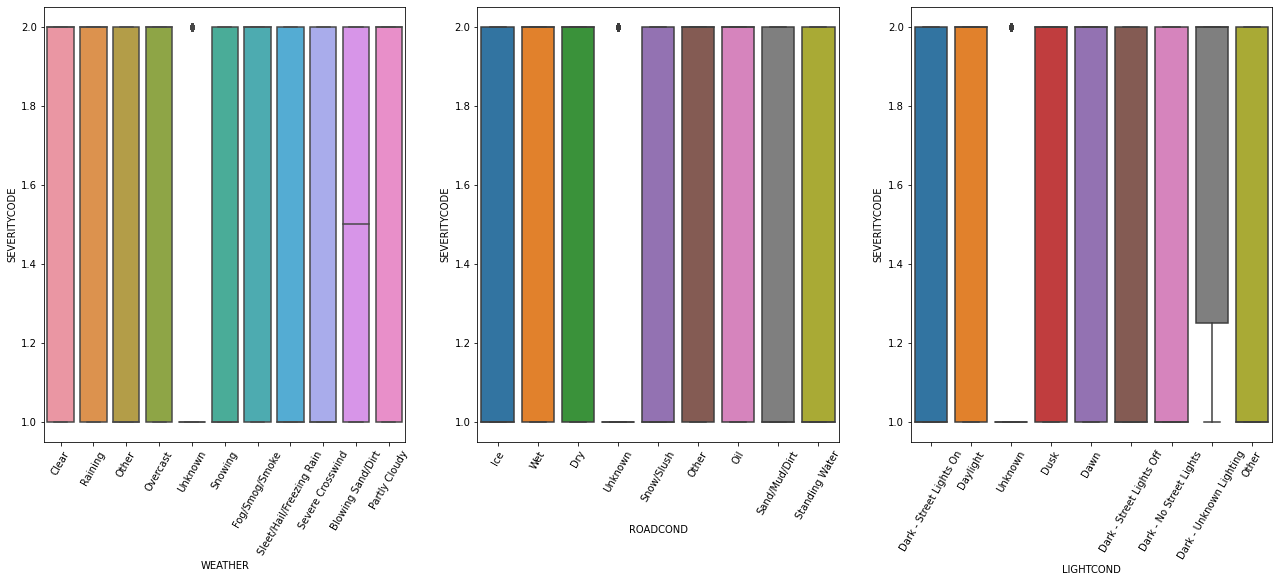

In [27]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(1, 3, 1)
sns.boxplot(data=df_collisions, x='WEATHER', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 2)
sns.boxplot(data=df_collisions, x='ROADCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 3)
sns.boxplot(data=df_collisions, x='LIGHTCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Dark - Street Lights On'),
  Text(1, 0, 'Daylight'),
  Text(2, 0, 'Unknown'),
  Text(3, 0, 'Dusk'),
  Text(4, 0, 'Dawn'),
  Text(5, 0, 'Dark - Street Lights Off'),
  Text(6, 0, 'Dark - No Street Lights'),
  Text(7, 0, 'Dark - Unknown Lighting'),
  Text(8, 0, 'Other')])

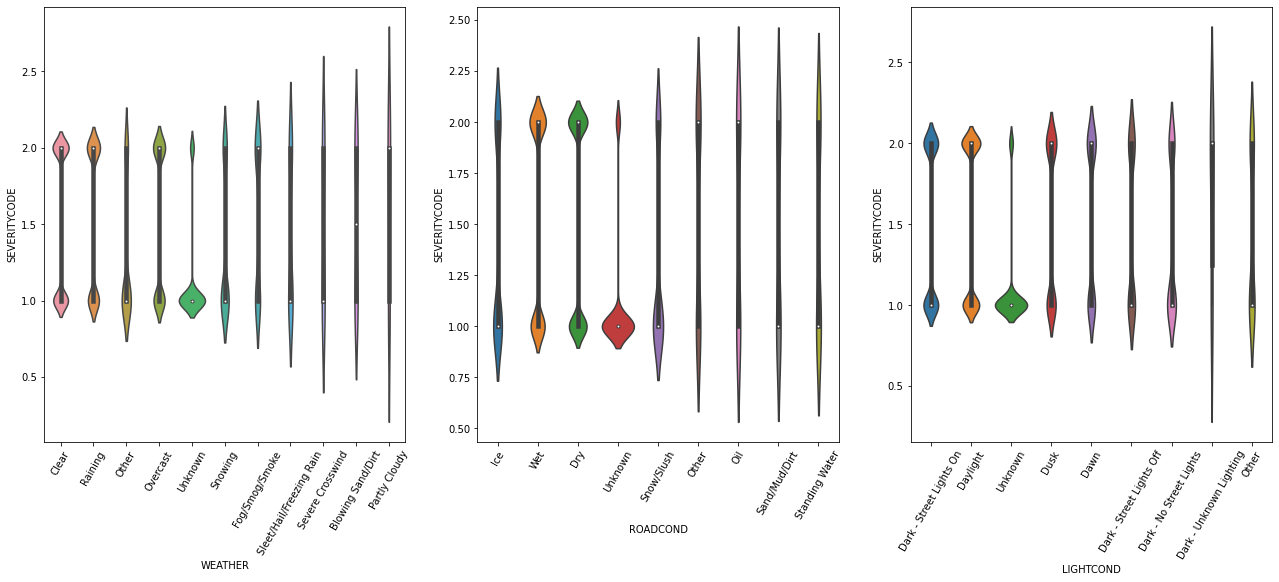

In [28]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(1, 3, 1)
sns.violinplot(data=df_collisions, x='WEATHER', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 2)
sns.violinplot(data=df_collisions, x='ROADCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 3)
sns.violinplot(data=df_collisions, x='LIGHTCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

These values have some numerical sequencing. Let's label encode this 3 columns:

In [29]:
le_weather = LabelEncoder()
df_collisions['WEATHER'] = le_weather.fit_transform(df_collisions['WEATHER'])

le_roadcond = LabelEncoder()
df_collisions['ROADCOND'] = le_roadcond.fit_transform(df_collisions['ROADCOND'])

le_lightcond = LabelEncoder()
df_collisions['LIGHTCOND'] = le_lightcond.fit_transform(df_collisions['LIGHTCOND'])

In [30]:
print(df_collisions.shape)

(116376, 21)


### Scatterplot

<AxesSubplot:xlabel='SEVERITYCODE', ylabel='VEHCOUNT'>

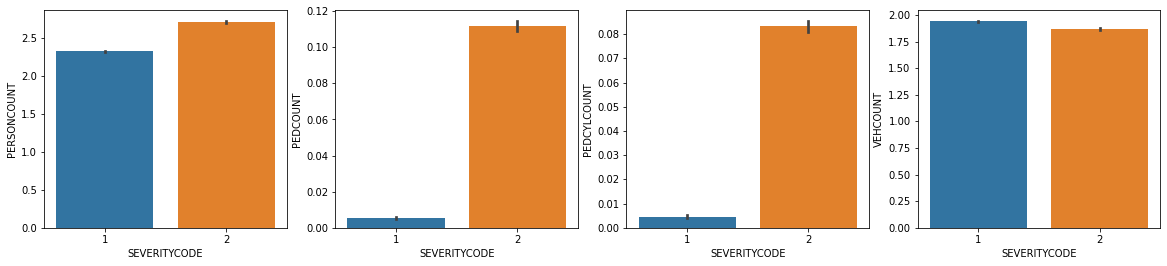

In [31]:
fig = plt.figure(figsize=(20, 4))

fig.add_subplot(1, 4, 1)
sns.barplot(data=df_collisions, x='SEVERITYCODE', y='PERSONCOUNT')

fig.add_subplot(1, 4, 2)
sns.barplot(data=df_collisions, x='SEVERITYCODE', y='PEDCOUNT')

fig.add_subplot(1, 4, 3)
sns.barplot(data=df_collisions, x='SEVERITYCODE', y='PEDCYLCOUNT')

fig.add_subplot(1, 4, 4)
sns.barplot(data=df_collisions, x='SEVERITYCODE', y='VEHCOUNT')

### Boxplot

<AxesSubplot:xlabel='SEVERITYCODE', ylabel='VEHCOUNT'>

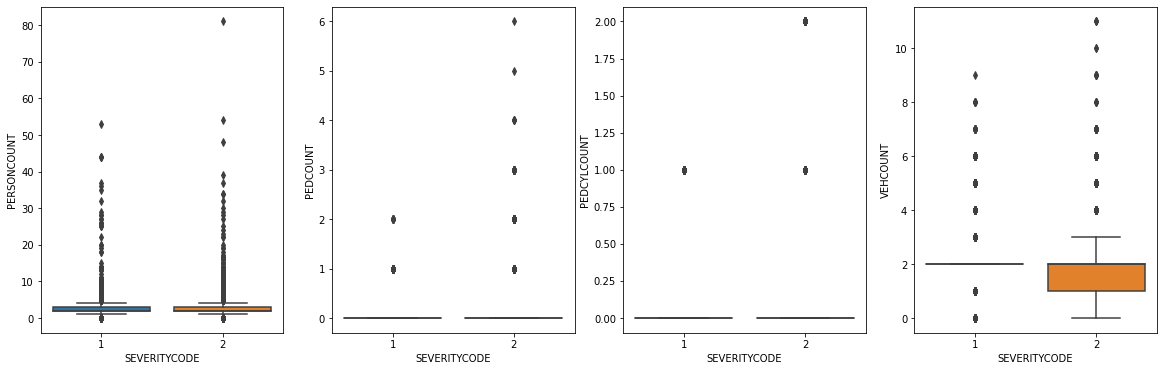

In [32]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1, 4, 1)
sns.boxplot(data=df_collisions, x='SEVERITYCODE', y='PERSONCOUNT')

fig.add_subplot(1, 4, 2)
sns.boxplot(data=df_collisions, x='SEVERITYCODE', y='PEDCOUNT')

fig.add_subplot(1, 4, 3)
sns.boxplot(data=df_collisions, x='SEVERITYCODE', y='PEDCYLCOUNT')

fig.add_subplot(1, 4, 4)
sns.boxplot(data=df_collisions, x='SEVERITYCODE', y='VEHCOUNT')

### Violinplot

<AxesSubplot:xlabel='SEVERITYCODE', ylabel='VEHCOUNT'>

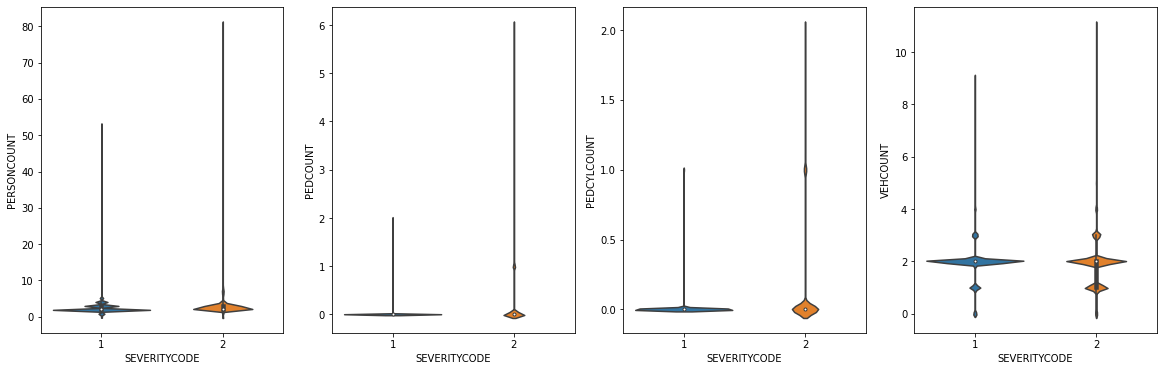

In [33]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1, 4, 1)
sns.violinplot(data=df_collisions, x='SEVERITYCODE', y='PERSONCOUNT')

fig.add_subplot(1, 4, 2)
sns.violinplot(data=df_collisions, x='SEVERITYCODE', y='PEDCOUNT')

fig.add_subplot(1, 4, 3)
sns.violinplot(data=df_collisions, x='SEVERITYCODE', y='PEDCYLCOUNT')

fig.add_subplot(1, 4, 4)
sns.violinplot(data=df_collisions, x='SEVERITYCODE', y='VEHCOUNT')

## Modeling <a name="modeling"></a>

Apesar da variável dependente ter um tipo INT64, estamos lidando com um problema de classificação, não de regressão, então usaremos alguns algoritmos visualizados no curso, e alguns estudados em outras plataformas, para tentar prever a gravidade de acidentes futuros.

O que precisamos fazer primeiro é escolher algumas colunas que tem mais impacto nos resultados finais, assim a gente evita que o algoritmo perca acuracia por estar lidando com variáveis inuteis

Pensei em utilizar K-nearest neighbors, Support Vector Machine, RandomForest e Logistic Regression para analisar os dados e ver qual deles se saí melhor no final.

### Feature selection

Now we have 21 columns. We can select a small set of columns to have a better accuracy using <b>SelectKBest</b>

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

In [35]:
min_max_scaler = MinMaxScaler()
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df_collisions.drop('SEVERITYCODE', axis=1)))

feature_selection = SelectKBest(score_func=chi2, k=15)

df_norm = feature_selection.fit_transform(df_norm, df_collisions['SEVERITYCODE'])

df_norm = pd.DataFrame(df_norm)

df_norm["SEVERITYCODE"] = df_collisions['SEVERITYCODE'].values

We can use pairplot to check binomial relation between the variables in our dataset. With this technique, we can choose the best ML algotithms to use.

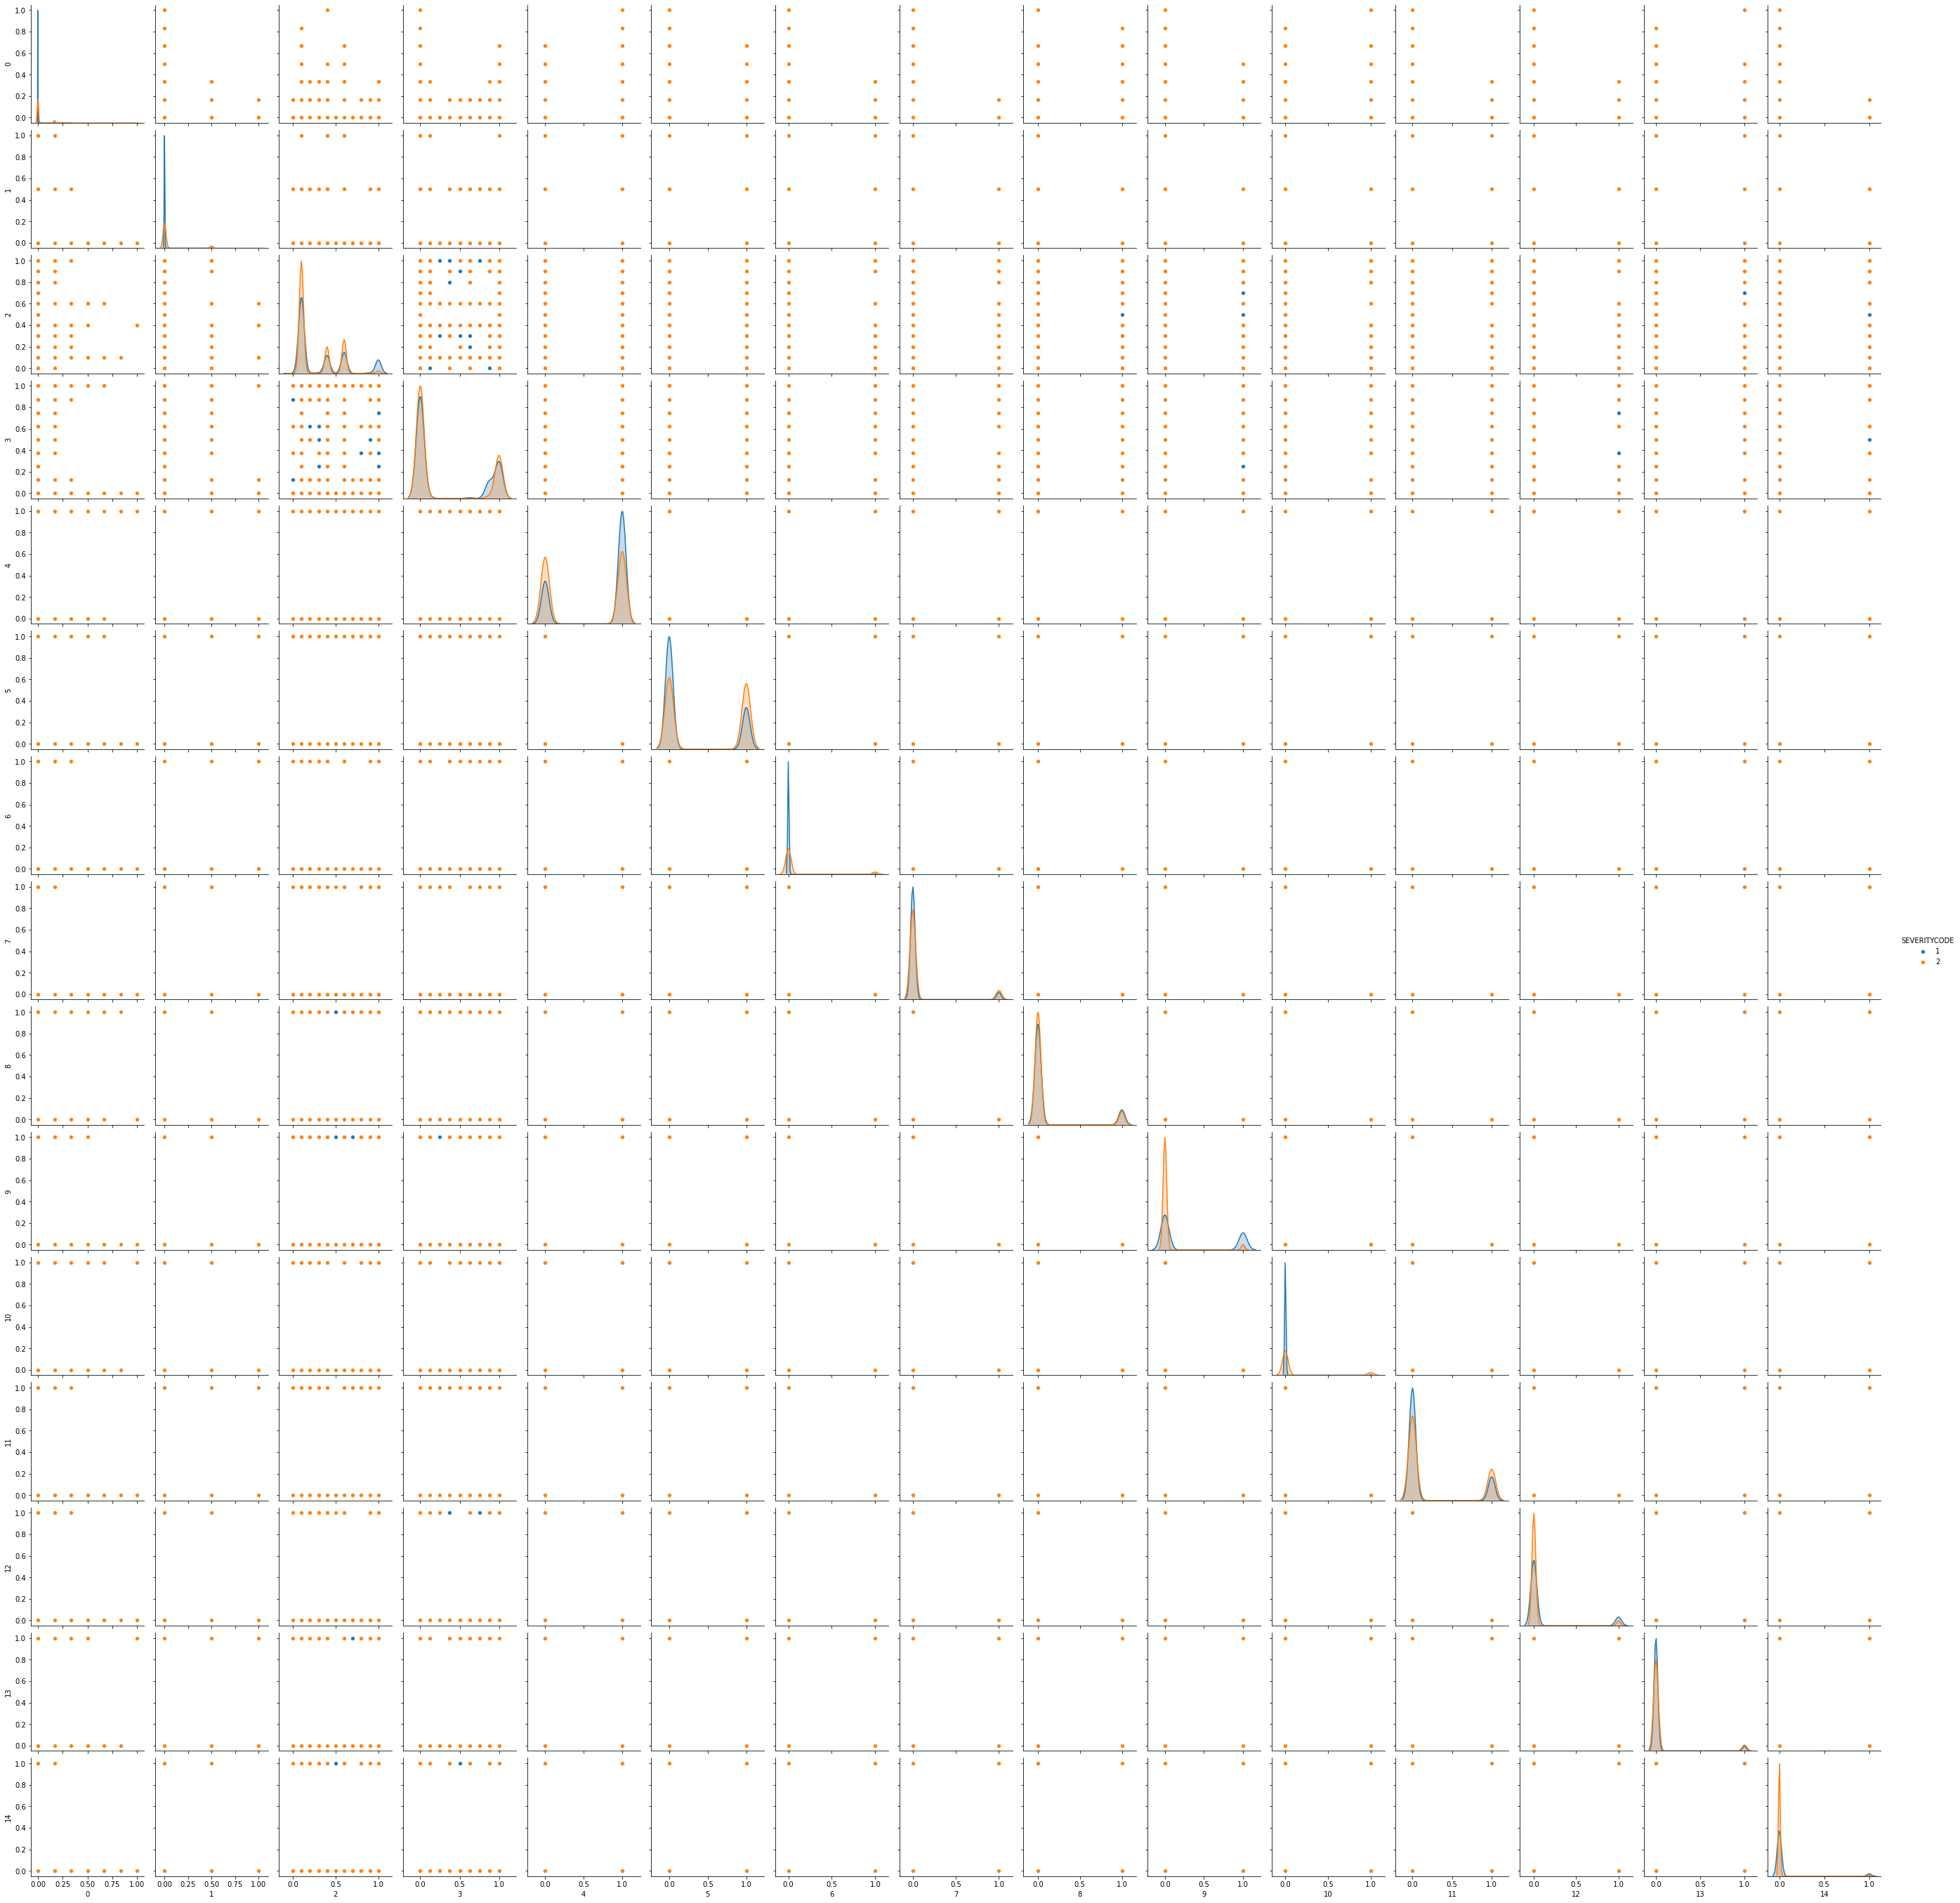

In [36]:
sns.pairplot(df_norm, hue='SEVERITYCODE')

Parece que não conseguimos desenhar uma linha para separar os dados, logo podemos ignorar o uso da Regressão Logística, já que ela consiste em desenhar uma linha reta para separar nossos dados.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Agora vamos separar parte dos dados para treinar nosso modelo e parte para testar a acuracia dos nossos algoritmos.

In [41]:
X = df_norm.drop('SEVERITYCODE', axis=1)
y = df_norm[['SEVERITYCODE']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(x_train.shape, y_train.shape)

(93100, 15) (93100, 1)


In [1]:
# Choosing the best K for Knearest-neighbors (KNN)

scores = np.zeros(11)
for k in range(1, 11):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train, y_train)
    scores[k-1] = knn_model.score(x_test, y_test)
best_knn_score = scores.max()
best_k = scores.argmax()+1

print("Best KNN score: " + str(best_knn_score) + " with K=" +str(best_k))

NameError: name 'np' is not defined

In [44]:
# KNN
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)

y_pred_knn = knn.predict(x_test)

In [45]:
# RandomForest
model_forest = RandomForestClassifier(n_estimators=20, criterion='entropy')
model_forest.fit(x_train, y_train)

y_pred_forest = model_forest.predict(x_test)

In [48]:
# SVM
model_svm = SVC(kernel='rbf')
model_svm.fit(x_train, y_train)

y_pred_svm = model_svm.predict(x_test)

## Evaluation <a name="evaluation"></a>

Agora, iremos verificar os resultados dos nossos algoritmos. Usaremos a função <b>classification_report</b> para avaliar a precision, recall e f1-score dos nossos algoritmos de classificação.

In [50]:
from sklearn.metrics import classification_report

In [51]:
print("KNN reports:" + classification_report(y_test, y_pred_knn))
print("Random Forest reports:" + classification_report(y_test, y_pred_forest))
print("SVM reports:" + classification_report(y_test, y_pred_svm))

KNN reports:              precision    recall  f1-score   support

           1       0.72      0.62      0.67     11624
           2       0.67      0.76      0.71     11652

    accuracy                           0.69     23276
   macro avg       0.69      0.69      0.69     23276
weighted avg       0.69      0.69      0.69     23276

Random Forest reports:              precision    recall  f1-score   support

           1       0.74      0.62      0.67     11624
           2       0.67      0.78      0.72     11652

    accuracy                           0.70     23276
   macro avg       0.71      0.70      0.70     23276
weighted avg       0.71      0.70      0.70     23276

SVM reports:              precision    recall  f1-score   support

           1       0.75      0.61      0.67     11624
           2       0.67      0.80      0.73     11652

    accuracy                           0.70     23276
   macro avg       0.71      0.70      0.70     23276
weighted avg       0.71     

## Conclusion <a name="conclusion"></a>

70% parece ser um resultado descente para esse projeto e baseando-se no fato de que temos poucos dados para treinar nossos algoritmos. Como o dataset era desbalanceado, precisamos remover muitas linhas e assim perdemos informação. 
Algo que não fizemos foi tentar ajustar paramêtros para os algoritmos, de inicio os resultados estão crus, mas em breve vamos adicionar novos paramêtros e comparar os resultados obtidos. Haja visto que todas as amostras colhidas e escolhidas foram aleatórias, podemos obter resultados diferentes, com certa variação, até para os métodos utilizados agora. Assim, irei considerar usar os paramêtros para ver se conseguimos obter um resultado bem melhor, algo em torno de 75%+ de média-ponderada na pontuação f1.